# LangChain + LangGraph workflow

This section wraps the existing KG extraction and Neo4j write-up into a LangGraph workflow. It:
- Builds `Document`s from sentences
- Extracts a knowledge graph with `LLMGraphTransformer`
- Writes it to Neo4j (with a helpful uniqueness constraint)
- Runs quick sanity checks and prints results

Requirements:
- Environment variables: `NEO4J_URI`, `NEO4J_USER`, `NEO4J_PASSWORD`
- Packages: `langchain-ollama`, `langchain-community`, `langchain-experimental`, `langgraph`, `neo4j`

You can run the demo cell below or call `run_workflow([...])` with your own sentences.

It assumes you have a local Ollama server installed with the `gemma3:27b-it-qat` model (or change the model name in the code):

```bash
OLLAMA_HOST=0.0.0.0 OLLAMA_CONTEXT_LENGTH=8192 OLLAMA_KV_CACHE_TYPE=q4_0 ollama start
```

In [1]:
# Cleaned & compact KG workflow
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Any, TypedDict, Optional, Tuple, Sequence

import os
import re
import logging
import difflib
from time import time
from functools import lru_cache
import yaml

from joblib import Memory
from tqdm.auto import tqdm
import pywikibot
from pywikibot.data.api import Request as ApiRequest
import html

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_community.graphs import Neo4jGraph
from langgraph.graph import StateGraph, START, END

# Judge
from t5_judge.judge import T5Judge

# Config + Logging

@dataclass(frozen=True)
class KGConfig:
    log_file: str = os.getenv("KG_LOG_FILE", "kg_workflow.log")
    log_format: str = os.getenv("KG_LOG_FORMAT", "%(asctime)s %(levelname)s - %(message)s")
    log_level: str = os.getenv("KG_LOG_LEVEL", "DEBUG")
    cache_dir: str = os.getenv("KG_CACHE_DIR", ".kg_cache")

    llm_provider: str = os.getenv("LLM_PROVIDER", "openai").lower()
    openai_model: str = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    openai_api_key: Optional[str] = os.getenv("OPENAI_API_KEY")
    ollama_base_url: str = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
    ollama_model: str = os.getenv("OLLAMA_MODEL", "gemma3:27b-it-qat")

    judge_model: str = os.getenv("KG_JUDGE_MODEL", "google/flan-t5-large")
    judge_action: str = os.getenv("KG_JUDGE_ACTION", "filter")  # or "annotate"

    wiki_lang_default: str = os.getenv("KG_WIKI_LANG", "en")


def setup_logging(cfg: KGConfig) -> logging.Logger:
    Path(cfg.log_file).parent.mkdir(parents=True, exist_ok=True)
    logging.basicConfig(
        filename=cfg.log_file,
        format=cfg.log_format,
        level=getattr(logging, cfg.log_level.upper(), logging.DEBUG),
        encoding="utf-8",
    )
    if os.getenv("KG_LOG_CONSOLE", "0") == "1":
        console = logging.StreamHandler()
        console.setFormatter(logging.Formatter(cfg.log_format))
        logging.getLogger().addHandler(console)
    return logging.getLogger("kg_disambiguation")


CFG = KGConfig()
logger = setup_logging(CFG)

# Caching for expensive ops
memory = Memory(location=CFG.cache_dir, verbose=0)

# Make pywikibot happy for read-only ops
os.environ.setdefault("PYWIKIBOT_NO_USER_CONFIG", "1")

# State definition

class KGState(TypedDict, total=False):
    sentences: List[str]
    docs: List[Document]
    graph_docs: List[Any]
    node_samples: List[Dict[str, Any]]
    rel_samples: List[Dict[str, Any]]
    summary: Dict[str, Any]
    # Disambiguation config + results
    disambiguate_labels: List[str]
    disambiguation_threshold: float
    canonical_map: Dict[str, Dict[str, str]]  # label -> {original_name: canonical_name}
    # Wikipedia grounding config
    ground_labels: List[str]
    wiki_language: str
    wiki_search_k: int
    wiki_match_threshold: float
    wiki_use_deepcat: bool
    wiki_query_hints: Dict[str, str]
    # Chunking
    chunk_target_bytes: int
    # Judge config + results
    judge_node_threshold: float
    judge_rel_threshold: float
    judge_model_name: str
    judge_device: str
    judge_batch_size: int
    judge_action: str  # 'filter' | 'annotate'
    judge_stats: Dict[str, Any]
    judge_results: List[Dict[str, Any]]

# Extraction config

allowed_nodes = [
    "Person",
    "Organization",
    "Product",
    "Location",
    "City",
    "Country",
    "Government Body",
    "Year",
]

allowed_relationships = [
    ("Person", "WORKS_FOR", "Organization"),
    ("Person", "FOUNDED", "Organization"),
    ("Organization", "ACQUIRED", "Organization"),
    ("Organization", "LOCATED_IN", "Location"),
    ("Person", "AFFILIATED_WITH", "Organization"),
    ("Organization", "COMPETES_WITH", "Organization"),
    ("Product", "MADE_BY", "Organization"),
    ("Organization", "PARTNERED_WITH", "Organization"),
    ("Product", "COMPETES_WITH", "Product"),
]

node_properties = [
    "name",
    "wiki_title",
    "wiki_pageid",
    "wiki_url",
    "wiki_lang",
    "wiki_description",
    "wikidata_id",
    "judge_score",
]

additional_instructions = (
    """
When extracting nodes, always include a 'name' property which should contain the text extracted.

Here are the definitions of the allowed node types:

- Person: An individual named human being, e.g., "John Doe", "Alice Smith".
- Organization: A group of people working together, e.g., "Apple Inc", "NASA".
- Product: A specific item produced for sale, e.g., "iPhone", "Microsoft Windows".
- Location: A specific place, e.g., "factory", or "office".
- City: A large town, e.g., "New York", "San Francisco".
- Country: A nation with its own government, e.g., "United States", "Canada".
- Government Body: An organization that governs a specific area, e.g., "United Nations", "Federal Reserve".
- Year: A specific year in time, e.g., "2020", "1999".
"""
)

# LLM factory + transformer

def make_llm(cfg: KGConfig):
    if cfg.llm_provider == "openai":
        return ChatOpenAI(model=cfg.openai_model, temperature=0, openai_api_key=cfg.openai_api_key)
    return ChatOllama(base_url=cfg.ollama_base_url, model=cfg.ollama_model, temperature=0)


llm = make_llm(CFG)

transformer = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=allowed_nodes,
    allowed_relationships=allowed_relationships,
    node_properties=node_properties,
    additional_instructions=additional_instructions,
    strict_mode=True,
)

# Small helpers

def _slugify(text: str) -> str:
    return re.sub(r"[^a-z0-9]+", "-", text.lower()).strip("-")


def _normalized_id(name: str, label: str) -> str:
    return f"{_slugify(name)}::{label}"


# Attr-or-dict tolerant accessors (kept to preserve compatibility with LangChain types)

def _get(obj: Any, name: str, default=None):
    if hasattr(obj, name):
        return getattr(obj, name)
    if isinstance(obj, dict):
        return obj.get(name, default)
    return default


def _set(obj: Any, name: str, value: Any):
    if hasattr(obj, name):
        setattr(obj, name, value)
    elif isinstance(obj, dict):
        obj[name] = value


def _ensure_node_props(node: Any) -> Dict[str, Any]:
    props = _get(node, "properties")
    if not isinstance(props, dict):
        props = {}
        _set(node, "properties", props)
    return props


def _ensure_rel_props(rel: Any) -> Dict[str, Any]:
    props = _get(rel, "properties")
    if not isinstance(props, dict):
        props = {}
        _set(rel, "properties", props)
    return props


def _get_node_label(node: Any) -> Optional[str]:
    return _get(node, "type")


def _get_node_id(node: Any) -> Optional[str]:
    return _get(node, "id")


def _get_node_name(node: Any) -> Optional[str]:
    props = _get(node, "properties") or {}
    if isinstance(props, dict):
        name = props.get("name")
        if name:
            return name
    return _get_node_id(node)


def _set_node_name(node: Any, new_name: str):
    props = _ensure_node_props(node)
    props["name"] = new_name


# Judge templates
ENTITY_TYPE_TEMPLATES: Dict[str, str] = {
    "Person": "is a person.",
    "Organization": "is an organization.",
    "Product": "is a product.",
    "Location": "is a location.",
    "City": "is a city.",
    "Country": "is a country.",
    "Government Body": "is a government body.",
    "Year": "is a year.",
}

RELATION_TEMPLATES: Dict[str, str] = {
    "WORKS_FOR": "{src} works for {tgt}.",
    "FOUNDED": "{src} founded {tgt}.",
    "ACQUIRED": "{src} acquired {tgt}.",
    "LOCATED_IN": "{src} is located in {tgt}.",
    "AFFILIATED_WITH": "{src} is affiliated with {tgt}.",
    "COMPETES_WITH": "{src} competes with {tgt}.",
    "MADE_BY": "{src} is made by {tgt}.",
    "PARTNERED_WITH": "{src} partnered with {tgt}.",
}

DEFAULT_WIKI_CATEGORY: Dict[str, str] = {
    "Organization": "Companies",
    "Product": "Products",
    "Person": "People",
    "Country": "Countries",
    "Government Body": "Government bodies",
    "Location": "Places",
}

# Optional: Reranker (clean + lazy)

try:
    from rerankers import Reranker
    from rerankers import Document as RRDocument
except Exception as e:
    Reranker = None
    RRDocument = None
    logger.debug("'rerankers' not available: %s", e)


@lru_cache(maxsize=1)
def _get_wiki_reranker(model_name: Optional[str] = None):
    if Reranker is None:
        return None
    name = model_name or os.getenv("RERANKERS_MODEL", "mixedbread-ai/mxbai-rerank-base-v1")
    try:
        return Reranker(name, model_type="cross-encoder", verbose=0)
    except Exception as e:
        logger.warning("Reranker init failed: %s", e)
        return None


# Wikipedia helpers

@memory.cache
def wiki_search_titles(query: str, lang: str, limit: int, hint: Optional[str], use_deepcat: bool) -> List[Dict[str, Any]]:
    if not query:
        return []
    try:
        pywikibot.config.user_agent = "PedroSearchBot/1.0"

        # Build the search string (CirrusSearch operators like intitle:, deepcat:)
        safe = re.sub(r"\s+", " ", query.strip().replace('"', ""))
        eff = f'intitle:"{safe}"'
        if use_deepcat and hint:
            eff += f' deepcat:"{hint}"'
        elif hint:
            eff += f" {hint}"

        site = pywikibot.Site(lang, "wikipedia")

        params = {
            "action": "query",
            "format": "json",
            "list": "search",
            "srsearch": eff,
            "srnamespace": 0,
            "srlimit": int(limit or 10),
            # Ask specifically for snippet and other useful props
            "srprop": "snippet|size|wordcount|timestamp|titlesnippet",
            # Optional: relevance (default) vs justmatch/newest/oldest, etc.
            # "srsort": "relevance",
        }
        data = ApiRequest(site=site, **params).submit()
        hits = data.get("query", {}).get("search", []) or []

        out: List[Dict[str, Any]] = []
        for h in hits:
            # Snippet comes HTML-escaped and with <span class="searchmatch">…</span>
            snippet_html = h.get("snippet") or ""
            out.append({
                "title": h.get("title"),
                "pageid": h.get("pageid"),
                "snippet": html.unescape(snippet_html),
                "wordcount": h.get("wordcount"),
                "size": h.get("size"),
                "timestamp": h.get("timestamp"),
            })
        return out

    except Exception as e:
        logger.warning("Wikipedia title search failed for %r: %s", query, e)
        return []



@memory.cache
def wiki_page_info(title: str, lang: str) -> Dict[str, Any]:
    try:
        site = pywikibot.Site(lang, "wikipedia")
        page = pywikibot.Page(site, title)
        props = page.properties()
        desc = page.description() if hasattr(page, "description") else None
        return {
            "pageid": page.pageid,
            "title": page.title(),
            "fullurl": page.full_url(),
            "description": desc,
            "wikidata_id": props.get("wikibase_item"),
        }
    except Exception as e:
        logger.warning("Wikipedia page info failed for title=%r: %s", title, e)
        return {}


def _best_wiki_match(query: str, results: List[Dict[str, Any]], thr: float, *, model_name: Optional[str] = None) -> Optional[Dict[str, Any]]:
    """Pick the best Wikipedia result.
    Order of preference: exact slug -> reranker (if available) -> difflib fallback.
    """
    if not results:
        return None

    q_slug = _slugify(query)
    for r in results:  # fast path exact slug
        if _slugify(r.get("title", "")) == q_slug:
            logger.debug("Exact slug match: %r", r.get("title"))
            return r

    # Try reranker if available
    rr = _get_wiki_reranker(model_name)
    if rr is not None and RRDocument is not None:
        # Log all titles considered
        logger.debug("Reranker candidates for %r: %s", query, ", ".join([r.get("title") for r in results if r.get("title")]))
        docs = [RRDocument(text=r["title"]+": "+r["snippet"], doc_id=str(i)) for i, r in enumerate(results) if r.get("title")]
        if docs:
            try:
                ranked = rr.rank(query=query, docs=docs) or []
                if ranked:
                    top = ranked[0]
                    score = float(getattr(top, "score", 0.0))
                    logger.debug("Reranker top: %r (%.4f)", getattr(top, "text", None), score)
                    if score >= thr:
                        by_title = {r["title"]: r for r in results if r.get("title")}
                        return by_title.get(getattr(top, "text", ""))
            except (RuntimeError, ValueError, AttributeError) as e:
                logger.debug("Reranker error, fallback to difflib: %s", e)

    # Fallback: difflib similarity
    scored = []
    ql = query.lower()
    for r in results:
        t = r.get("title", "")
        if not t:
            continue
        ratio = difflib.SequenceMatcher(a=ql, b=t.lower()).ratio()
        scored.append((ratio, r))
    if not scored:
        return None
    scored.sort(key=lambda x: x[0], reverse=True)
    best_ratio, best = scored[0]
    logger.debug("Fallback best: %r (%.4f)", best.get("title"), best_ratio)
    return best if best_ratio >= thr else None


# Relationship id remap

def _remap_relationship_ids(doc: Any, id_map: Dict[str, str]) -> Dict[str, int]:
    rel_src, rel_tgt = 0, 0
    for rel in getattr(doc, "relationships", []):
        src = _get(rel, "source"); tgt = _get(rel, "target")
        src_id = _get(src, "id") if not isinstance(src, str) else src
        tgt_id = _get(tgt, "id") if not isinstance(tgt, str) else tgt
        if src_id in id_map:
            if isinstance(src, str):
                _set(rel, "source", id_map[src_id])
            else:
                _set(src, "id", id_map[src_id])
            rel_src += 1
        if tgt_id in id_map:
            if isinstance(tgt, str):
                _set(rel, "target", id_map[tgt_id])
            else:
                _set(tgt, "id", id_map[tgt_id])
            rel_tgt += 1
    return {"rel_src": rel_src, "rel_tgt": rel_tgt}


# Nodes

def build_docs(state: KGState) -> KGState:
    sentences = state.get("sentences") or []
    if not sentences:
        raise ValueError("No sentences provided in state['sentences']")
    return {"docs": [Document(page_content=s, metadata={"source": "workflow"}) for s in sentences]}


def extract_graph(state: KGState) -> KGState:
    docs = state.get("docs") or []
    if not docs:
        return {"graph_docs": [], "summary": {"node_count": 0, "relationship_count": 0}}

    batch_size = int(state.get("extract_batch_size") or os.getenv("KG_EXTRACT_BATCH_SIZE", "8"))

    graph_docs, errors = [], 0
    with tqdm(total=len(docs), desc="Extract graph", unit="doc") as pbar:
        for start in range(0, len(docs), batch_size):
            batch = docs[start : start + batch_size]
            try:
                gds = transformer.convert_to_graph_documents(batch)
                graph_docs.extend(gds)
            except Exception as e:
                logger.warning("Failed to extract batch %d:%d: %s", start, start + len(batch), e)
                errors += len(batch)
            finally:
                pbar.update(len(batch))

    summary = {
        "node_count": sum(len(d.nodes) for d in graph_docs),
        "relationship_count": sum(len(d.relationships) for d in graph_docs),
        "batch_size": batch_size,
    }
    if errors:
        summary["errors"] = errors
    return {"graph_docs": graph_docs, "summary": summary}

# Doc chunker

def chunk_docs(state: KGState) -> KGState:
    """
    Split state['docs'] into semantically-meaningful ~1 KB chunks using semchunk.
    - Targets ~256 tokens per chunk (≈ 1 KB at ~4 chars/token).
    - Overlap ~10% (configurable).
    - Preserves and augments metadata (parent doc tracking + byte offsets).
    """
    try:
        import semchunk
    except Exception as e:
        raise RuntimeError(
            "semchunk is required. Install with: pip install semchunk"
        ) from e

    # Prefer a tokenizer that matches your LLM; fall back safely.
    enc = None
    try:
        import tiktoken
        # Try to match OpenAI model if used; otherwise fall back to cl100k_base
        # (o200k_base suits GPT-4o/GPT-4.1 families; cl100k_base is broadly OK).
        if CFG.llm_provider != "openai":
            openai_model = None
        else:
            openai_model = CFG.openai_model
        try:
            enc = tiktoken.encoding_for_model(openai_model) if openai_model else tiktoken.get_encoding("cl100k_base")
        except Exception:
            # 4o/4.1 often map to o200k_base; try that before final fallback
            try:
                enc = tiktoken.get_encoding("o200k_base")
            except Exception:
                enc = tiktoken.get_encoding("cl100k_base")
        def token_counter(s: str) -> int:
            return len(enc.encode(s))
    except Exception:
        # Minimal heuristic if tiktoken unavailable: ~4 chars/token
        token_counter = lambda s: max(1, len(s) // 4)

    # Config knobs (can be set in state)
    target_bytes = int(state.get("chunk_target_bytes") or 1024)        # ≈ 1 KB
    # Approx chars≈bytes; tokens≈chars/4
    chunk_size_tokens = int(state.get("chunk_size_tokens") or max(1, target_bytes // 4))
    overlap_tokens = state.get("chunk_overlap_tokens")
    if overlap_tokens is None:
        overlap_tokens = max(1, int(0.1 * chunk_size_tokens))          # ~10% overlap

    # Build the chunker
    # semchunk.chunkerify accepts a tokenizer OR a token counter callable (+ size)
    chunker = semchunk.chunkerify(token_counter, chunk_size=chunk_size_tokens)

    docs = state.get("docs") or []
    if not docs:
        return {"docs": []}

    chunked_docs: List[Document] = []
    for doc_idx, doc in enumerate(tqdm(docs, total=len(docs), desc="Chunk docs", unit="doc")):
        text = getattr(doc, "page_content", "") or ""
        if not text.strip():
            continue

        # Ask for offsets so we can keep byte/char ranges
        chunks, offsets = chunker(text, offsets=True, overlap=overlap_tokens)

        parent_id = _slugify(f"{_get(doc, 'metadata', {}).get('source', 'doc')}-{doc_idx}")
        base_meta = dict(getattr(doc, "metadata", {}) or {})
        base_meta.setdefault("source", base_meta.get("source", "workflow"))
        base_meta["parent_id"] = parent_id
        base_meta["parent_len"] = len(text)
        base_meta["chunk_size_tokens"] = chunk_size_tokens
        base_meta["chunk_overlap_tokens"] = overlap_tokens

        for i, (chunk, (start, end)) in enumerate(zip(chunks, offsets)):
            md = dict(base_meta)
            md.update({
                "chunk_index": i,
                "chunk_start": int(start),
                "chunk_end": int(end),
            })
            chunked_docs.append(Document(page_content=chunk, metadata=md))

    return {"docs": chunked_docs}

# Judge

# batched scoring with keep-on-error semantics
def _batch_scores_safe(judge: T5Judge,
                       pairs: Sequence[Tuple[str, str]],
                       batch_size: int = 16) -> List[float]:
    """Return list of truth_scores for each (evidence, fact). On error, returns 0.0 for all."""
    try:
        results = judge.batch_judge_claims(pairs, batch_size=batch_size)
        return [float(r.truth_score) for r in results]
    except (RuntimeError, ValueError) as e:
        logger.debug("Judge batch error on %d pairs: %s", len(pairs), e)
        return [0.0] * len(pairs)


def validate_with_judge(state: KGState) -> KGState:
    node_thr = float(state.get("judge_node_threshold") or 0.4)
    rel_thr = float(state.get("judge_rel_threshold") or 0.4)
    model_name = state.get("judge_model_name") or CFG.judge_model
    device = state.get("judge_device")
    action = (state.get("judge_action") or CFG.judge_action).lower()
    keep_all = action == "annotate"
    batch_size = int(state.get("judge_batch_size") or 16)

    try:
        judge = T5Judge(model_name=model_name, device=device)
    except Exception as e:
        logger.warning("Judge initialization failed (%s). Skipping validation.", e)
        return {}

    judge_results: List[Dict[str, object]] = []

    docs = state.get("docs") or []
    gdocs = state.get("graph_docs") or []
    if not docs or not gdocs:
        return {}

    updated_docs: List[Any] = []
    stats = {"nodes_removed": 0, "rels_removed": 0, "nodes_kept": 0, "rels_kept": 0, "mode": action}

    for doc, gd in tqdm(zip(docs, gdocs), total=min(len(docs), len(gdocs)), desc="Judge validation", unit="doc"):
        evidence = getattr(doc, "page_content", None) or ""

        # NODES (batched)
        node_items: List[Tuple[Any, str, str, str]] = []  # (node, label, name, fact_str)
        node_pairs: List[Tuple[str, str]] = []            # (evidence, fact)
        node_indices: List[int] = []                      # map back to node_items

        # collect
        for idx, node in enumerate(getattr(gd, "nodes", [])):
            lbl = _get_node_label(node)
            name = _get_node_name(node) or ""
            if not lbl or not name:
                if keep_all:
                    # keep but without score
                    logger.debug("Judge node: missing label or name; keeping as-is: %r", node)
                    _ensure_node_props(node).setdefault("judge_score", 0.0)
                    stats["nodes_kept"] += 1
                else:
                    stats["nodes_removed"] += 1
                continue
            tpl = ENTITY_TYPE_TEMPLATES.get(lbl)
            if not tpl:
                # unknown template -> keep as-is
                stats["nodes_kept"] += 1
                continue
            fact_str = f"{name} {tpl}"
            node_items.append((node, lbl, name, fact_str))
            node_pairs.append((evidence, fact_str))
            node_indices.append(len(node_items) - 1)

        # score batch
        node_scores: List[float] = _batch_scores_safe(judge, node_pairs, batch_size=batch_size) if node_pairs else []

        # apply decisions
        new_nodes: List[Any] = []
        valid_ids: set = set()
        for (node, lbl, name, fact_str), score in zip(node_items, node_scores):
            ok = (score >= node_thr) or keep_all
            # log & annotate
            judge_results.append({
                'type': 'node',
                'name': lbl,
                'fact': fact_str,
                'evidence': evidence,
                'score': score,
                'accepted': bool(score >= node_thr)
            })
            logger.debug("Judge node: %r %r -> %s (%.4f)", lbl, name, "ACCEPT" if (score >= node_thr) else "REJECT", score)
            _ensure_node_props(node)["judge_score"] = score

            if ok:
                new_nodes.append(node)
                nid = _get_node_id(node)
                if nid:
                    valid_ids.add(nid)
                stats["nodes_kept"] += 1
            else:
                stats["nodes_removed"] += 1

        # also carry over any previously kept nodes that weren’t scored (no tpl / missing name/label but kept in annotate)
        # We already accounted stats for those above; ensure they remain in graph:
        # Rebuild by iterating original nodes, keeping those that either were added as ok, or were kept earlier.
        if keep_all:
            # in annotate mode, keep all original nodes, but ensure judge_score is set for scored ones
            original_nodes = getattr(gd, "nodes", [])
            # avoid duplicates: use id set
            kept_ids = { _get_node_id(n) for n in new_nodes if _get_node_id(n) }
            for n in original_nodes:
                nid = _get_node_id(n)
                if nid and nid in kept_ids:
                    continue
                # if not already included, keep as-is (with possible default score)
                _ensure_node_props(n).setdefault("judge_score", 0.0)
                new_nodes.append(n)
                if nid:
                    valid_ids.add(nid)

        _set(gd, "nodes", new_nodes)

        # RELATIONSHIPS (batched)
        rel_items: List[Tuple[Any, str, str]] = []   # (rel, rtype, fact_str)
        rel_pairs: List[Tuple[str, str]] = []

        def _name_of(id_):
            for n in new_nodes:
                if _get_node_id(n) == id_:
                    return _get_node_name(n) or id_
            return id_

        for rel in getattr(gd, "relationships", []):
            rtype = _get(rel, "type") or _get(rel, "label")
            src = _get(rel, "source"); tgt = _get(rel, "target")
            src_id = _get(src, "id") if not isinstance(src, str) else src
            tgt_id = _get(tgt, "id") if not isinstance(tgt, str) else tgt

            if not rtype or not src_id or not tgt_id:
                if keep_all:
                    # keep, annotate later with 0.0 if needed
                    _ensure_rel_props(rel).setdefault("judge_score", 0.0)
                    rel_items.append((rel, None, None))  # mark for unconditional keep
                else:
                    stats["rels_removed"] += 1
                continue

            if not keep_all and (src_id not in valid_ids or tgt_id not in valid_ids):
                stats["rels_removed"] += 1
                continue

            tpl = RELATION_TEMPLATES.get(rtype)
            if not tpl:
                # keep as-is, no scoring
                rel_items.append((rel, None, None))
                continue

            fact_str = tpl.format(src=_name_of(src_id), tgt=_name_of(tgt_id))
            rel_items.append((rel, rtype, fact_str))
            rel_pairs.append((evidence, fact_str))

        rel_scores: List[float] = _batch_scores_safe(judge, rel_pairs, batch_size=batch_size) if rel_pairs else []

        new_rels: List[Any] = []
        score_iter = iter(rel_scores)
        for rel, rtype, fact_str in rel_items:
            if rtype is None:
                # unscored but kept
                new_rels.append(rel)
                stats["rels_kept"] += 1
                continue

            score = next(score_iter)
            ok = (score >= rel_thr) or keep_all

            judge_results.append({
                'type': 'relation',
                'name': rtype,
                'fact': fact_str,
                'evidence': evidence,
                'score': score,
                'accepted': bool(score >= rel_thr)
            })
            logger.debug("Judge rel: %r %r -> %s (%.4f)", rtype, fact_str, "ACCEPT" if (score >= rel_thr) else "REJECT", score)
            _ensure_rel_props(rel)["judge_score"] = score

            if ok:
                new_rels.append(rel)
                stats["rels_kept"] += 1
            else:
                stats["rels_removed"] += 1

        _set(gd, "relationships", new_rels)
        updated_docs.append(gd)

    logger.info("Judge done (mode=%s). nodes_kept=%d nodes_removed=%d rels_kept=%d rels_removed=%d",
                action, stats["nodes_kept"], stats["nodes_removed"], stats["rels_kept"], stats["rels_removed"])
    return {"graph_docs": updated_docs, "judge_stats": stats, "judge_results": judge_results}


# Disambiguation (sentence-transformers)

def disambiguate_entities(state: KGState) -> KGState:
    labels = state.get("disambiguate_labels") or ["Product"]
    threshold = state.get("disambiguation_threshold") or 0.85
    logger.info("Disambiguation start: labels=%s threshold=%.2f", labels, threshold)

    try:
        from sentence_transformers import SentenceTransformer, util
    except Exception as e:
        raise EnvironmentError(
            "sentence-transformers is required for disambiguation. Install with: pip install sentence-transformers"
        ) from e

    # Build contextual mentions per label: each mention carries the surface name and a snippet of its source document.
    docs = state.get("docs") or []
    gdocs = state.get("graph_docs") or []

    def _context_snippet(text: str, name: str, max_chars: int = 512) -> str:
        try:
            if not text:
                return ""
            t = text
            needle = (name or "").lower()
            idx = t.lower().find(needle) if needle else -1
            if idx == -1:
                return t[:max_chars]
            half = max_chars // 2
            start = max(0, idx - half)
            end = min(len(t), idx + len(name or "") + half)
            return t[start:end]
        except Exception:
            return (text or "")[:max_chars]

    per_label_mentions: Dict[str, List[Dict[str, Any]]] = {lbl: [] for lbl in labels}
    for i, gd in enumerate(gdocs):
        evidence = getattr(docs[i], "page_content", "") if i < len(docs) else ""
        for node in getattr(gd, "nodes", []):
            label = _get_node_label(node)
            if label in labels:
                name = _get_node_name(node)
                if not name:
                    continue
                ctx = _context_snippet(evidence, name, max_chars=512)
                embed_text = f"[{label}] {name}\nContext: {ctx}"
                per_label_mentions[label].append({"name": name, "embed_text": embed_text})

    if all(len(v) == 0 for v in per_label_mentions.values()):
        logger.info("No names found for configured labels; skipping disambiguation.")
        return {"canonical_map": {}}

    model = SentenceTransformer("Qwen/Qwen3-Embedding-4B")

    # Cluster contextual mentions and convert to a per-name canonical map by majority voting.
    canonical_map: Dict[str, Dict[str, str]] = {lbl: {} for lbl in labels}
    for label, mentions in per_label_mentions.items():
        if not mentions:
            continue
        texts = [m["embed_text"] for m in mentions]
        logger.debug("Encoding %d mentions for label %s: %s", len(texts), label, texts)
        emb = model.encode(texts, convert_to_tensor=True, normalize_embeddings=True)
        clusters = util.community_detection(emb, threshold=threshold, min_community_size=1)
        logger.info("Label %s clustered into %d groups", label, len(clusters))

        # votes[name][canonical] = count
        votes: Dict[str, Dict[str, int]] = {}
        for cl in clusters:
            cl_names = [mentions[idx]["name"] for idx in cl]
            canonical = max(cl_names, key=len)
            for n in cl_names:
                votes.setdefault(n, {})
                votes[n][canonical] = votes[n].get(canonical, 0) + 1
                if n != canonical:
                    logger.debug("Cluster [%s]: '%s' -> '%s'", label, n, canonical)

        for n, cand_counts in votes.items():
            # choose the canonical with max votes; tie-break by longest candidate
            best_canonical = sorted(cand_counts.items(), key=lambda kv: (kv[1], len(kv[0])), reverse=True)[0][0]
            canonical_map[label][n] = best_canonical

    # Write the canonical_map to 'canonical_map.yaml' for inspection/debugging.
    with open('canonical_map.yaml', 'w') as f:
        yaml.dump(canonical_map, f)

    # Apply canonical surface forms to nodes and keep graph consistency.
    # - Iterate each graph document and build a per-document id_map (old_id -> new_id).
    # - For nodes whose label is in the configured disambiguation set:
    #   * Replace the 'name' with its canonical form from canonical_map when different.
    #   * Recompute the node 'id' as "<slug(name)>::<Label>" and update if it changes.
    #   * Record any id change in id_map to later rewrite relationship endpoints.
    # - After all nodes in a document are updated, update relationships with _remap_relationship_ids
    #   using the accumulated id_map so edges still point to the correct nodes.
    # - Track counts of name/id updates and relationship endpoint rewrites; accumulate updated docs.
    updated_docs = []
    total_id_changes = total_name_changes = total_rel_src_changes = total_rel_tgt_changes = 0
    for doc in state["graph_docs"]:
        id_map: Dict[str, str] = {}
        for node in getattr(doc, "nodes", []):
            label = _get_node_label(node)
            if label in labels:
                old_name = _get_node_name(node)
                new_name = canonical_map.get(label, {}).get(old_name, old_name)
                if new_name and new_name != old_name:
                    logger.info("Name remap [%s]: '%s' -> '%s'", label, old_name, new_name)
                    _set_node_name(node, new_name)
                    total_name_changes += 1
                old_id = _get_node_id(node) or _slugify(str(old_name))
                new_id = _normalized_id(new_name or old_name, label)
                if new_id != old_id:
                    logger.info("ID remap   [%s]: '%s' -> '%s'", label, old_id, new_id)
                    _set(node, "id", new_id)
                    id_map[old_id] = new_id
                    total_id_changes += 1
        rel_stats = _remap_relationship_ids(doc, id_map)
        total_rel_src_changes += rel_stats["rel_src"]
        total_rel_tgt_changes += rel_stats["rel_tgt"]
        updated_docs.append(doc)

    logger.info(
        "Disambiguation done. name_changes=%d id_changes=%d rel_src_updates=%d rel_tgt_updates=%d",
        total_name_changes, total_id_changes, total_rel_src_changes, total_rel_tgt_changes,
    )
    return {"graph_docs": updated_docs, "canonical_map": canonical_map}


# Wikipedia grounding

def ground_with_wikipedia(state: KGState) -> KGState:
    labels = state.get("ground_labels") or ["Organization", "Product"]
    lang = state.get("wiki_language") or CFG.wiki_lang_default
    k = int(state.get("wiki_search_k") or 5)
    use_deepcat = bool(state.get("wiki_use_deepcat") or False)
    threshold = float(state.get("wiki_match_threshold") or 0.9)
    hints_map: Dict[str, str] = state.get("wiki_query_hints") or {}

    logger.info(
        "Wikipedia grounding start: labels=%s lang=%s k=%d threshold=%.2f",
        labels, lang, k, threshold,
    )

    updated_docs = []
    total_name_changes = total_id_changes = total_rel_src_changes = total_rel_tgt_changes = grounded_nodes_count = 0
    docs = state.get("docs") or []

    for idx, gd in enumerate(tqdm(state["graph_docs"], desc="Wikipedia grounding", unit="doc")):
        id_map: Dict[str, str] = {}
        evidence = getattr(docs[idx], "page_content", "") if idx < len(docs) else ""
        _ = evidence  # currently unused, kept for future heuristics
        for node in getattr(gd, "nodes", []):
            lbl = _get_node_label(node)
            if lbl not in labels:
                continue
            query = _get_node_name(node)
            if not query:
                continue
            hint = hints_map.get(lbl) or DEFAULT_WIKI_CATEGORY.get(lbl)
            results = wiki_search_titles(query, lang=lang, limit=k, hint=hint, use_deepcat=use_deepcat)
            best = _best_wiki_match(query, results, threshold)
            if not best:
                continue
            title = best.get("title") or query
            info = wiki_page_info(title, lang=lang)
            fullurl = info.get("fullurl") or f"https://{lang}.wikipedia.org/wiki/{title.replace(' ', '_')}"
            pageid = info.get("pageid") or best.get("pageid")

            old_name = _get_node_name(node)
            props = _ensure_node_props(node)
            props.update({
                "wiki_title": title,
                "wiki_pageid": pageid,
                "wiki_url": fullurl,
                "wiki_lang": lang,
            })
            if info.get("description") is not None:
                props["wiki_description"] = info.get("description")
            if info.get("wikidata_id") is not None:
                props["wikidata_id"] = info.get("wikidata_id")

            logger.info(
                "Enriched wiki [%s]: name='%s', title='%s', pageid=%s, qid=%s, url=%s (hint=%s)",
                lbl, old_name, title, str(pageid), str(info.get("wikidata_id")), fullurl, hint,
            )
            grounded_nodes_count += 1

            if title and title != old_name:
                logger.info("Ground name [%s]: '%s' -> '%s'", lbl, old_name, title)
                _set_node_name(node, title)
                total_name_changes += 1
            old_id = _get_node_id(node) or _slugify(str(old_name))
            new_id = _normalized_id(title or old_name, lbl)
            if new_id != old_id:
                logger.info("Ground id   [%s]: '%s' -> '%s'", lbl, old_id, new_id)
                _set(node, "id", new_id)
                id_map[old_id] = new_id
                total_id_changes += 1

        rel_stats = _remap_relationship_ids(gd, id_map)
        total_rel_src_changes += rel_stats["rel_src"]
        total_rel_tgt_changes += rel_stats["rel_tgt"]
        updated_docs.append(gd)

    logger.info(
        "Wikipedia grounding done. grounded_nodes=%d name_changes=%d id_changes=%d rel_src_updates=%d rel_tgt_updates=%d",
        grounded_nodes_count, total_name_changes, total_id_changes, total_rel_src_changes, total_rel_tgt_changes,
    )
    return {"graph_docs": updated_docs}


# Neo4j ingestions

_NEO4J_GRAPH_SINGLETON: Optional[Neo4jGraph] = None

def _get_neo4j_graph() -> Neo4jGraph:
    global _NEO4J_GRAPH_SINGLETON
    if _NEO4J_GRAPH_SINGLETON is None:
        for k in ("NEO4J_URI", "NEO4J_USER", "NEO4J_PASSWORD"):
            if not os.environ.get(k):
                raise EnvironmentError(f"Missing environment variable: {k}")
        _NEO4J_GRAPH_SINGLETON = Neo4jGraph(
            url=os.environ["NEO4J_URI"],
            username=os.environ["NEO4J_USER"],
            password=os.environ["NEO4J_PASSWORD"],
        )
        _NEO4J_GRAPH_SINGLETON.query(
            """
            CREATE CONSTRAINT entity_id_unique IF NOT EXISTS
            FOR (n:Entity) REQUIRE n.id IS UNIQUE
            """
        )
    return _NEO4J_GRAPH_SINGLETON


def write_to_neo4j(state: KGState) -> KGState:
    graph = _get_neo4j_graph()
    graph.add_graph_documents(state["graph_docs"], include_source=True)
    return {}


def sanity_checks(state: KGState) -> KGState:
    graph = _get_neo4j_graph()
    node_rows = graph.query(
        """
        MATCH (n:Entity)
        RETURN
          n.name AS name,
          n.wiki_title AS wiki_title,
          n.wikidata_id AS wikidata_id,
          n.wiki_url AS wiki_url,
          n.wiki_pageid AS wiki_pageid,
          n.wiki_lang AS wiki_lang,
          n.wiki_description AS wiki_description,
          labels(n) AS labels
        LIMIT 10
        """
    )
    rel_rows = graph.query(
        """
        MATCH (a)-[r]->(b)
        RETURN a.name AS from, TYPE(r) AS rel, b.name AS to, r.source AS source
        LIMIT 10
        """
    )
    wiki_counts = graph.query(
        """
        MATCH (n:Entity)
        RETURN
          count(n) AS total_nodes,
          sum(CASE WHEN n.wiki_title IS NOT NULL THEN 1 ELSE 0 END) AS grounded_nodes,
          sum(CASE WHEN n.wikidata_id IS NOT NULL THEN 1 ELSE 0 END) AS with_wikidata
        """
    )
    return {"node_samples": node_rows, "rel_samples": rel_rows, "wiki_counts": wiki_counts}


# Graph wiring

builder = StateGraph(KGState)
builder.add_node("build_docs", build_docs)
builder.add_node("chunk_docs", chunk_docs)
builder.add_node("extract_graph", extract_graph)
# validation
builder.add_node("validate_with_judge", validate_with_judge)
builder.add_node("disambiguate_entities", disambiguate_entities)
builder.add_node("ground_with_wikipedia", ground_with_wikipedia)
# io
builder.add_node("write_to_neo4j", write_to_neo4j)
builder.add_node("sanity_checks", sanity_checks)

builder.add_edge(START, "build_docs")
builder.add_edge("build_docs", "chunk_docs")
builder.add_edge("chunk_docs", "extract_graph")
# judge first, then disambiguation, then grounding
builder.add_edge("extract_graph", "validate_with_judge")
builder.add_edge("validate_with_judge", "disambiguate_entities")
# builder.add_edge("disambiguate_entities", "ground_with_wikipedia")
# builder.add_edge("ground_with_wikipedia", "write_to_neo4j")
builder.add_edge("disambiguate_entities", "write_to_neo4j")
builder.add_edge("write_to_neo4j", "sanity_checks")
builder.add_edge("sanity_checks", END)

workflow = builder.compile()


# Demo: load HF dataset and run

def load_bloomberg_texts(max_items: int = 200, seed: int = 42, keywords: Optional[List[str]] = None) -> List[str]:
    """Load Bloomberg pretraining dataset, clean, keyword-filter, and sample texts."""
    try:
        from datasets import load_dataset
    except Exception as e:
        raise RuntimeError(
            "HuggingFace 'datasets' is required. Install with: pip install datasets"
        ) from e

    ds = load_dataset("Aletheia-ng/bloomberg-news-articles-pretraining-dataset")
    split_name = "train" if "train" in ds else next(iter(ds.keys()))
    split = ds[split_name]

    raw_texts = [t for t in split["text"] if isinstance(t, str) and t.strip()]

    # Truncate boilerplate like: "To contact the reporters on this story ..."
    cleaned = [re.split(r"To contact the reporters? on this story", t)[0].strip() for t in raw_texts]

    kws = keywords or ["Apple", "Google", "Microsoft", "Amazon"]
    pat = re.compile("|".join(map(re.escape, kws)), re.IGNORECASE)
    filtered = [t for t in cleaned if pat.search(t)]

    if not filtered:
        raise ValueError("No texts matched the keyword filter; adjust 'keywords'.")

    import random
    random.seed(seed)
    sampled = random.sample(filtered, min(max_items, len(filtered)))
    logger.info("Selected %d texts for processing out of %d after keyword filter (%s)", len(sampled), len(filtered), ", ".join(kws))
    return sampled


# Entry point

def run_workflow(
    sentences: List[str],
    *,
    chunk_target_bytes: Optional[int] = None,
    disambiguate_labels: Optional[List[str]] = None,
    disambiguation_threshold: Optional[float] = None,
    ground_labels: Optional[List[str]] = None,
    wiki_language: Optional[str] = None,
    wiki_search_k: Optional[int] = None,
    wiki_match_threshold: Optional[float] = None,
    wiki_use_deepcat: Optional[bool] = None,
    wiki_query_hints: Optional[Dict[str, str]] = None,
    judge_batch_size: Optional[int] = None,
    judge_node_threshold: Optional[float] = None,
    judge_rel_threshold: Optional[float] = None,
    judge_model_name: Optional[str] = None,
    judge_action: Optional[str] = None,
) -> KGState:
    pipeline_setup: KGState = {"sentences": sentences}

    if chunk_target_bytes is not None: pipeline_setup["chunk_target_bytes"] = chunk_target_bytes
    if disambiguate_labels is not None: pipeline_setup["disambiguate_labels"] = disambiguate_labels
    if disambiguation_threshold is not None: pipeline_setup["disambiguation_threshold"] = disambiguation_threshold
    if ground_labels is not None: pipeline_setup["ground_labels"] = ground_labels
    if wiki_language is not None: pipeline_setup["wiki_language"] = wiki_language
    if wiki_search_k is not None: pipeline_setup["wiki_search_k"] = wiki_search_k
    if wiki_use_deepcat is not None: pipeline_setup["wiki_use_deepcat"] = wiki_use_deepcat
    if wiki_match_threshold is not None: pipeline_setup["wiki_match_threshold"] = wiki_match_threshold
    if wiki_query_hints is not None: pipeline_setup["wiki_query_hints"] = wiki_query_hints
    if judge_batch_size is not None: pipeline_setup["judge_batch_size"] = judge_batch_size
    if judge_node_threshold is not None: pipeline_setup["judge_node_threshold"] = judge_node_threshold
    if judge_rel_threshold is not None: pipeline_setup["judge_rel_threshold"] = judge_rel_threshold
    if judge_model_name is not None: pipeline_setup["judge_model_name"] = judge_model_name
    if judge_action is not None: pipeline_setup["judge_action"] = judge_action

    result_state = workflow.invoke(pipeline_setup)
    summary = result_state.get("summary", {})
    print(f"Extracted {summary.get('node_count', 0)} nodes and {summary.get('relationship_count', 0)} relationships.")
    if result_state.get("canonical_map"):
        print("\nDisambiguation applied for labels:")
        for lbl, mp in result_state["canonical_map"].items():
            if mp:
                print(f"- {lbl}: {len(mp)} names mapped")

    return result_state


def run_demo_from_hf_dataset() -> pd.DataFrame:
    """Convenience runner that pulls a sample from HF and executes the workflow."""
    sampled_texts = load_bloomberg_texts(max_items=500, seed=42,
                                         keywords=["Apple", "Google", "Microsoft", "Amazon"]) 
    print(f"Selected {len(sampled_texts)} texts for processing.")

    state = run_workflow(
        sampled_texts,
        chunk_target_bytes=2048,
        disambiguate_labels=["Product", "Organization", "Country", "Government Body", "Person", "Location", "City"],
        disambiguation_threshold=1.0,
        ground_labels=["Product", "Organization", "Country", "Government Body", "Person", "Location", "City"],
        wiki_language="en",
        wiki_search_k=50,
        wiki_use_deepcat=False,
        wiki_match_threshold=0.9,  # works well for title similarity; reranker path also uses this threshold
        judge_batch_size=8,
        judge_node_threshold=0.3,
        judge_rel_threshold=0.3,
        judge_model_name="google/flan-t5-xl",
        judge_action="annotate",  # set to 'filter' to drop low-confidence items
    )
    
    return state.get('judge_results')


In [2]:
judge_results = run_demo_from_hf_dataset()

Selected 500 texts for processing.


Chunk docs:   0%|          | 0/500 [00:00<?, ?doc/s]

Extract graph:   0%|          | 0/1860 [00:00<?, ?doc/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Judge validation:   0%|          | 0/1860 [00:00<?, ?doc/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Batches:   0%|          | 0/229 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

/tmp/ipykernel_232368/653381802.py:987: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  _NEO4J_GRAPH_SINGLETON = Neo4jGraph(


Extracted 18662 nodes and 4308 relationships.

Disambiguation applied for labels:
- Product: 739 names mapped
- Organization: 2508 names mapped
- Country: 99 names mapped
- Person: 1985 names mapped
- Location: 300 names mapped
- City: 286 names mapped


In [3]:
# Convert judge results to a DataFrame for easier inspection
df = pd.DataFrame(judge_results)

# Save to a CSV
df.to_csv('judge_results.csv', index=False)

# Show summary statistics
total_judged = len(df)
accepted = df['accepted'].sum()
rejected = total_judged - accepted
print(f"\nTotal judged items: {total_judged}")
print(f"Accepted: {accepted}")
print(f"Rejected: {rejected}")

# Show the columns of the DataFrame
print("\nColumns in the judge results DataFrame:")
print(df.columns.tolist())




Total judged items: 22654
Accepted: 18656
Rejected: 3998

Columns in the judge results DataFrame:
['type', 'name', 'fact', 'evidence', 'score', 'accepted']


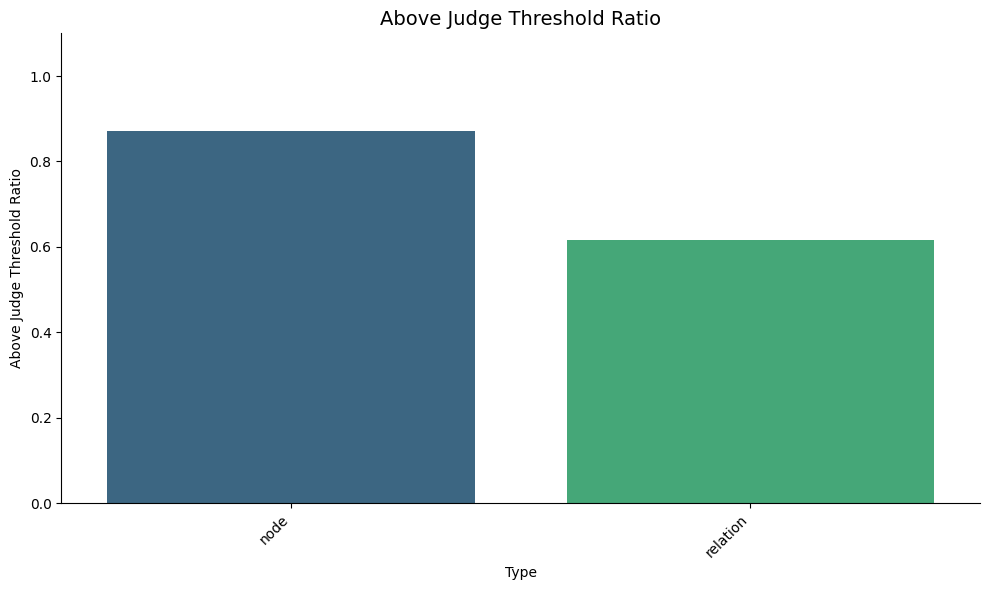

In [4]:
# compute acceptance ratio and counts
summary = (
    df.groupby("type")
      .agg(acceptance_ratio=("accepted", "mean"),
           count=("accepted", "size"))
      .reset_index()
      .sort_values("acceptance_ratio", ascending=False)
)

# plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=summary,
    x="type", y="acceptance_ratio",
    palette="viridis",
    hue="type"
)

ax.set_title("Above Judge Threshold Ratio", fontsize=14)
ax.set_xlabel("Type")
ax.set_ylabel("Above Judge Threshold Ratio")
ax.set_ylim(0, 1.1)  # leave room for labels
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()

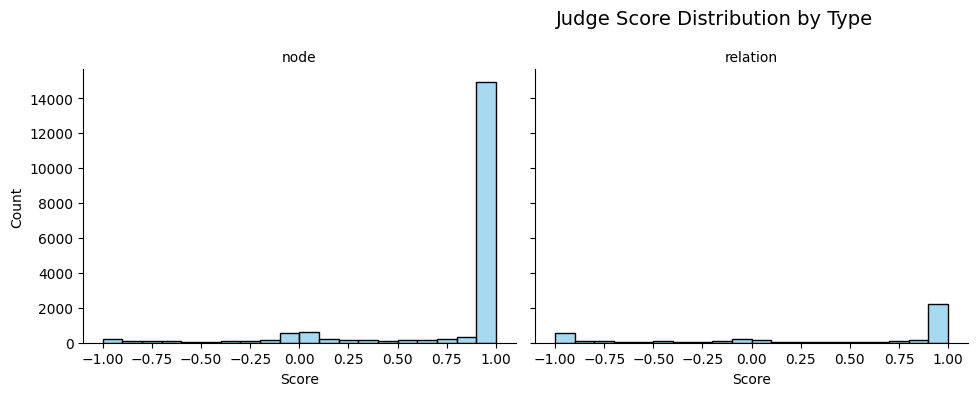

In [5]:
g = sns.FacetGrid(
    df,
    col="type",
    col_wrap=3,
    sharex=True,
    sharey=True,
    height=4,      # height of each subplot in inches
    aspect=1.2     # width = height * aspect
)
g.map_dataframe(sns.histplot, x="score", color="skyblue", bins=20)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Score", "Count")
g.fig.suptitle("Judge Score Distribution by Type", fontsize=14)
plt.tight_layout()
plt.show()



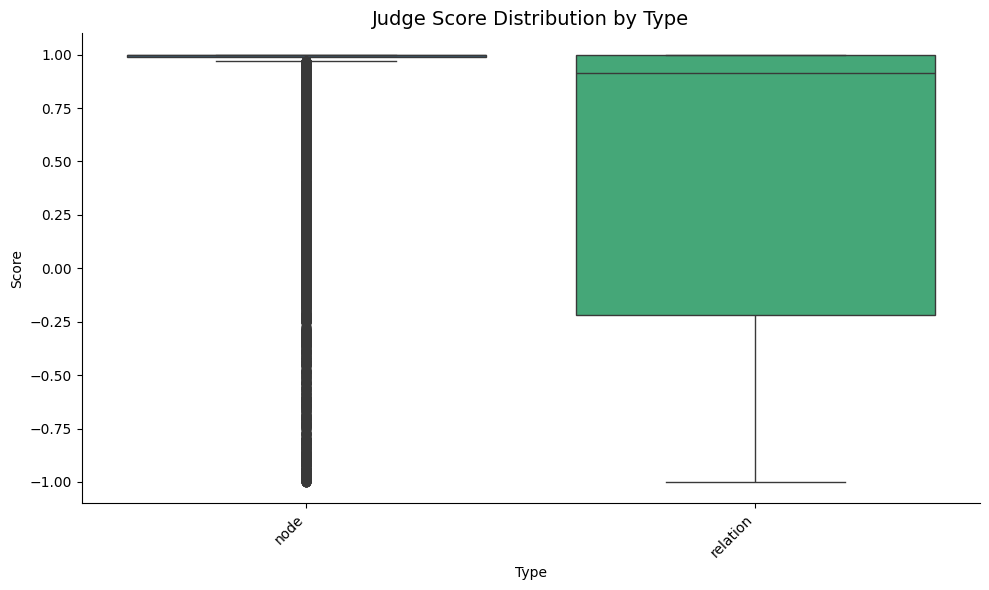

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="type", y="score",
    palette="viridis",
    hue="type"
)
plt.title("Judge Score Distribution by Type", fontsize=14)
plt.xlabel("Type")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()


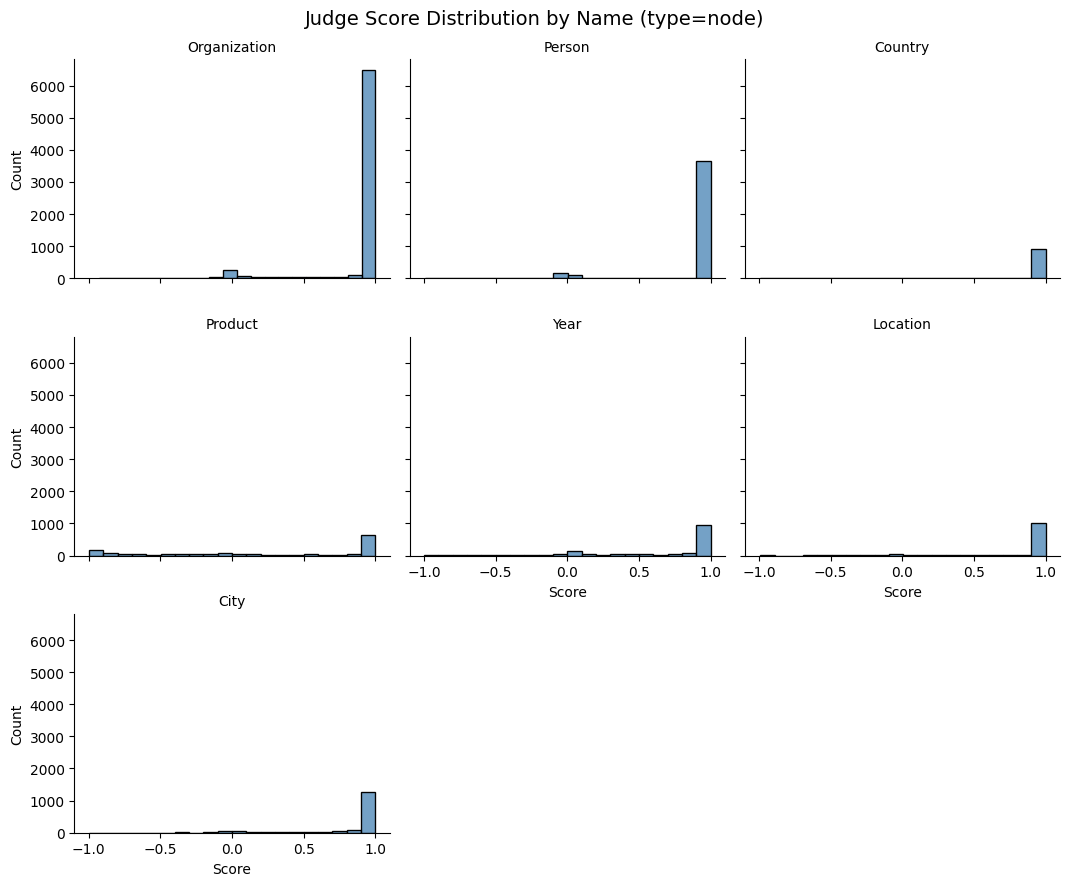

In [7]:

df_node = df[df["type"] == "node"]

# plot histograms by name
g = sns.FacetGrid(
    df_node,
    col="name",
    col_wrap=3,       # adjust for how many unique names you have
    sharex=True,
    sharey=True,
    height=3,
    aspect=1.2
)
g.map_dataframe(sns.histplot, x="score", color="steelblue", bins=20)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Score", "Count")
g.fig.suptitle("Judge Score Distribution by Name (type=node)", fontsize=14)
plt.tight_layout()
plt.show()


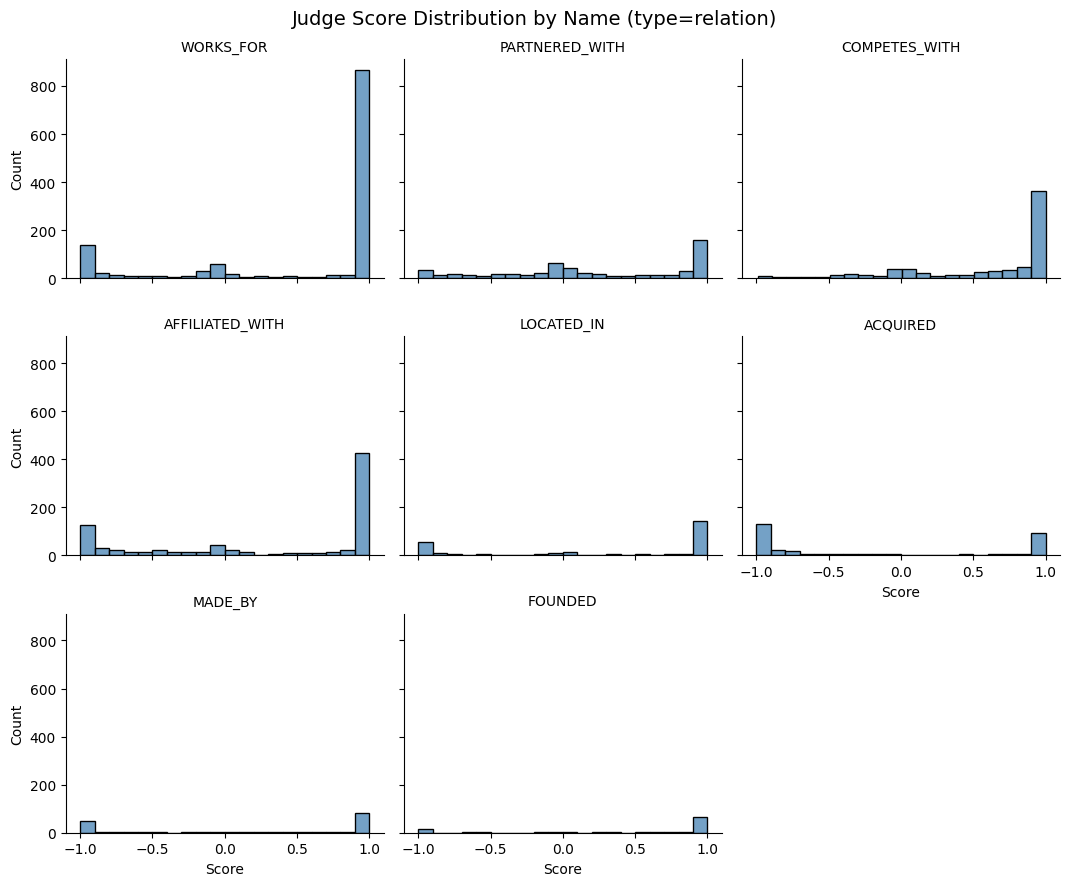

In [8]:

df_node = df[df["type"] == "relation"]

# plot histograms by name
g = sns.FacetGrid(
    df_node,
    col="name",
    col_wrap=3,       # adjust for how many unique names you have
    sharex=True,
    sharey=True,
    height=3,
    aspect=1.2
)
g.map_dataframe(sns.histplot, x="score", color="steelblue", bins=20)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Score", "Count")
g.fig.suptitle("Judge Score Distribution by Name (type=relation)", fontsize=14)
plt.tight_layout()
plt.show()